In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
import os
import itertools as it
import math
import shapely

(2081, 1901)


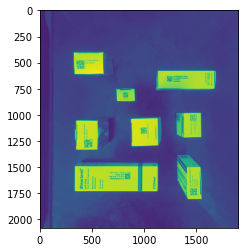

In [13]:
path1 = 'C:/Users/User/Desktop/Box_and_Barcode_Detector/images/easier/plate2.jpg'

image_coloured = cv2.imread(path1)
image = cv2.cvtColor(image_coloured, cv2.COLOR_BGR2GRAY)
image_h, image_w =image.shape
print(image.shape)
plt.imshow(image)

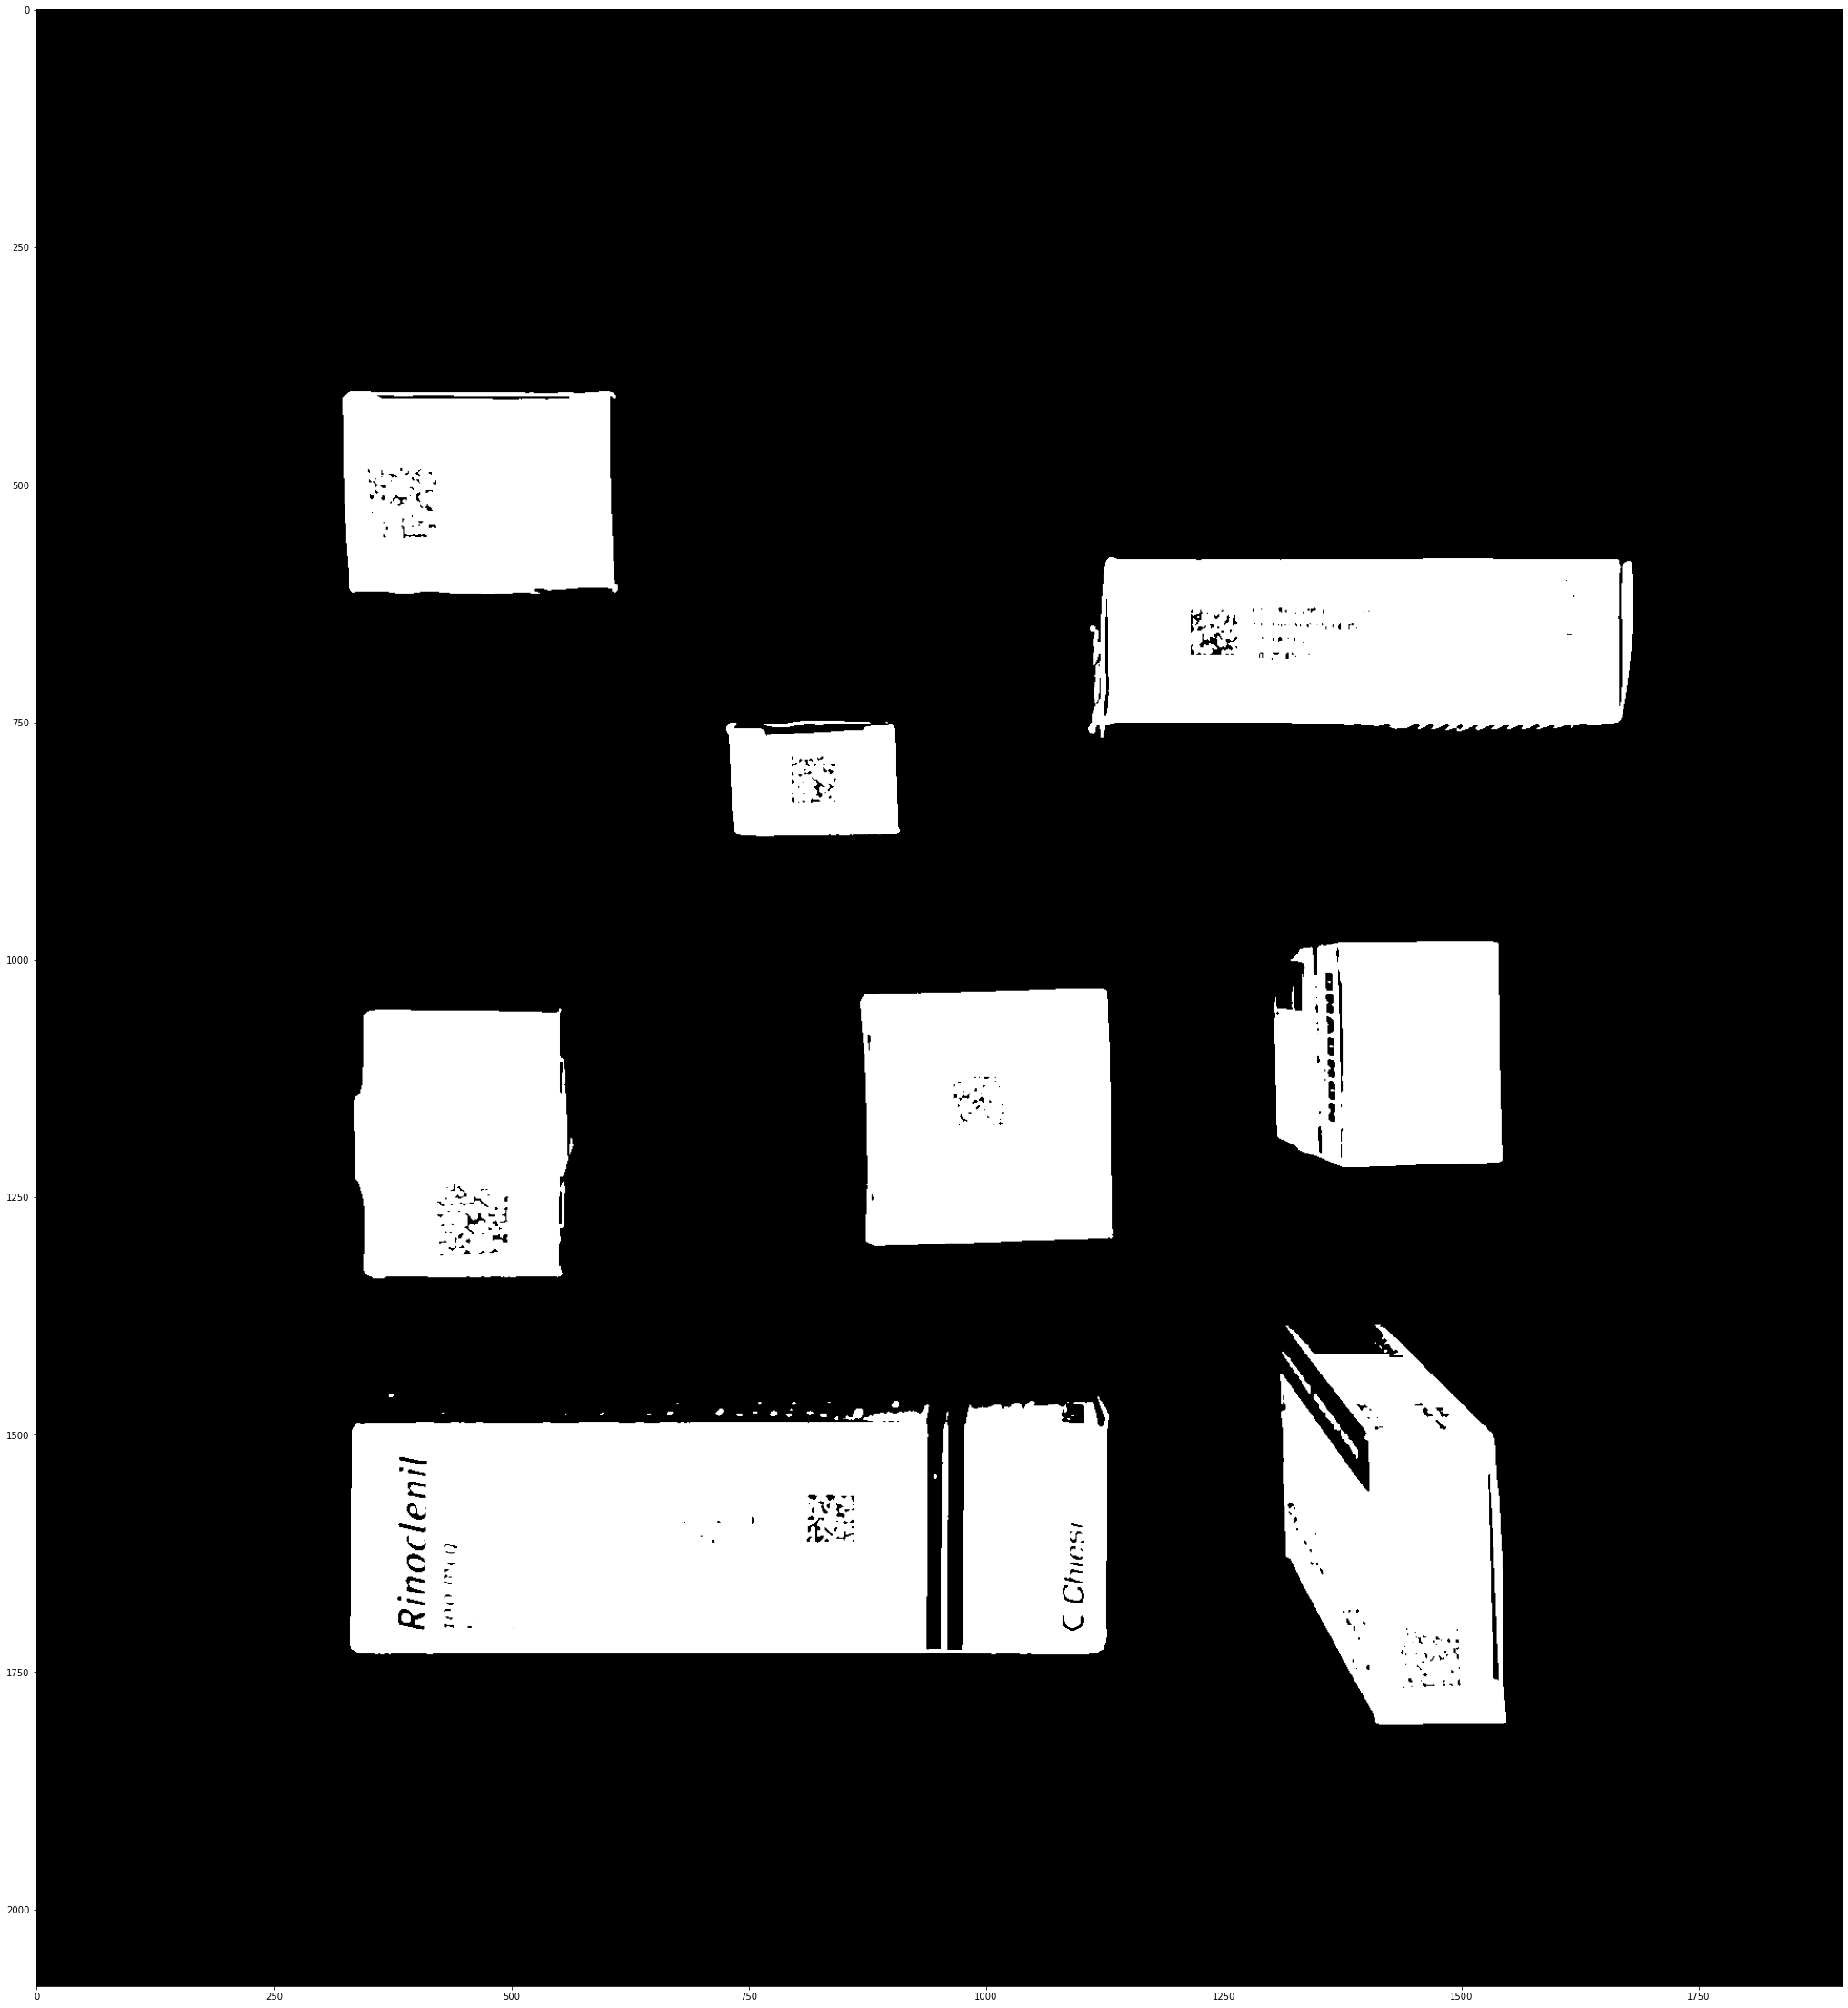

In [15]:
#median blur helps to eliminate salt&pepper noise - if it lowers DataMatrix decoding accuracy, it can be changed or eliminated.
#ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
#masked = th1*image

#adapt_mean = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,35,2)


blur = cv2.GaussianBlur(image,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blurred_new = th3

plt.figure(figsize=(40,40))

plt.imshow(th3,'gray')


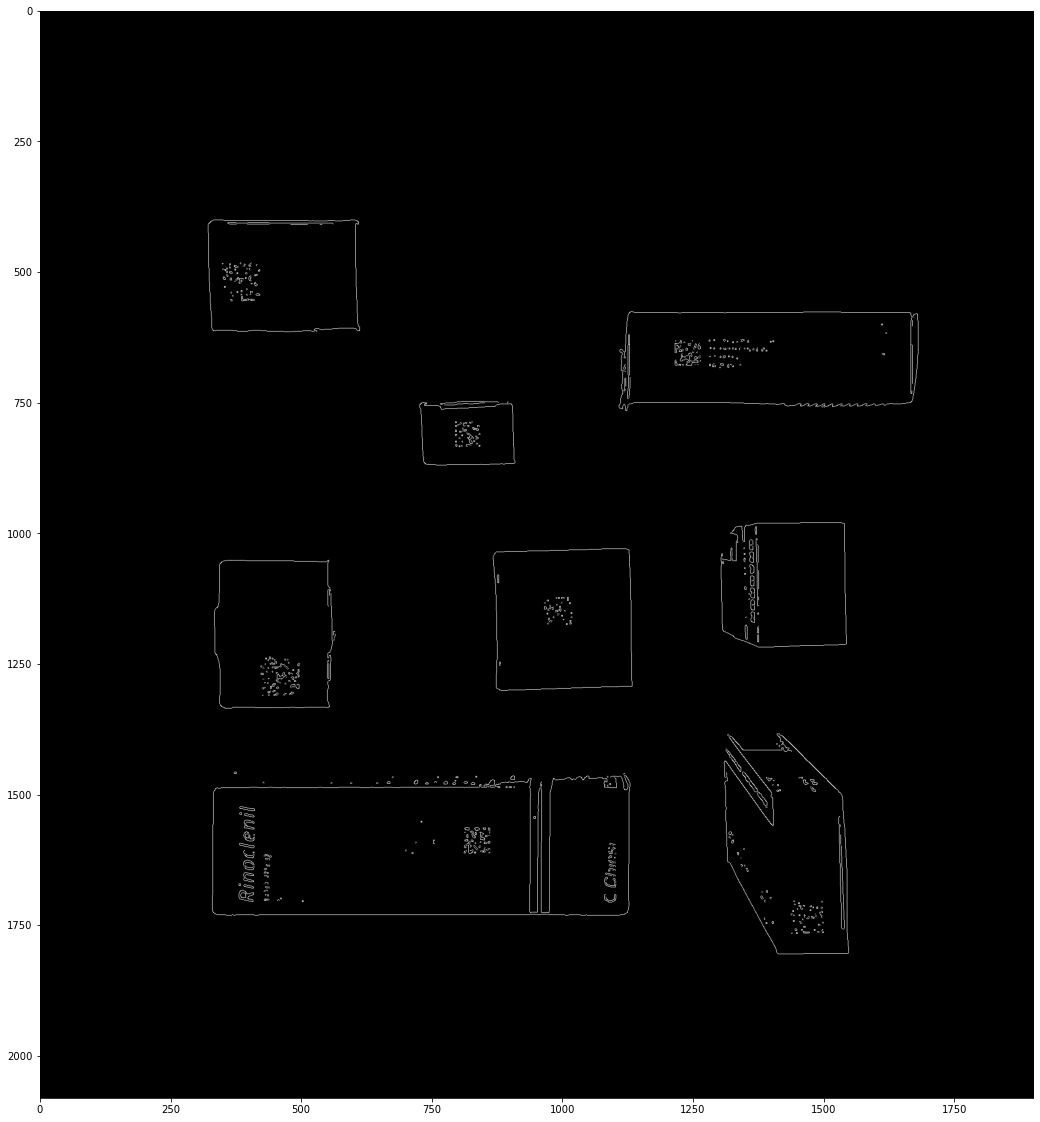

In [16]:

v = np.median(blurred_new)
sigma = 0.33

#---- Apply automatic Canny edge detection using the computed median----

lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edged = cv2.Canny(blurred_new, lower, upper)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(edged,cmap ='gray')


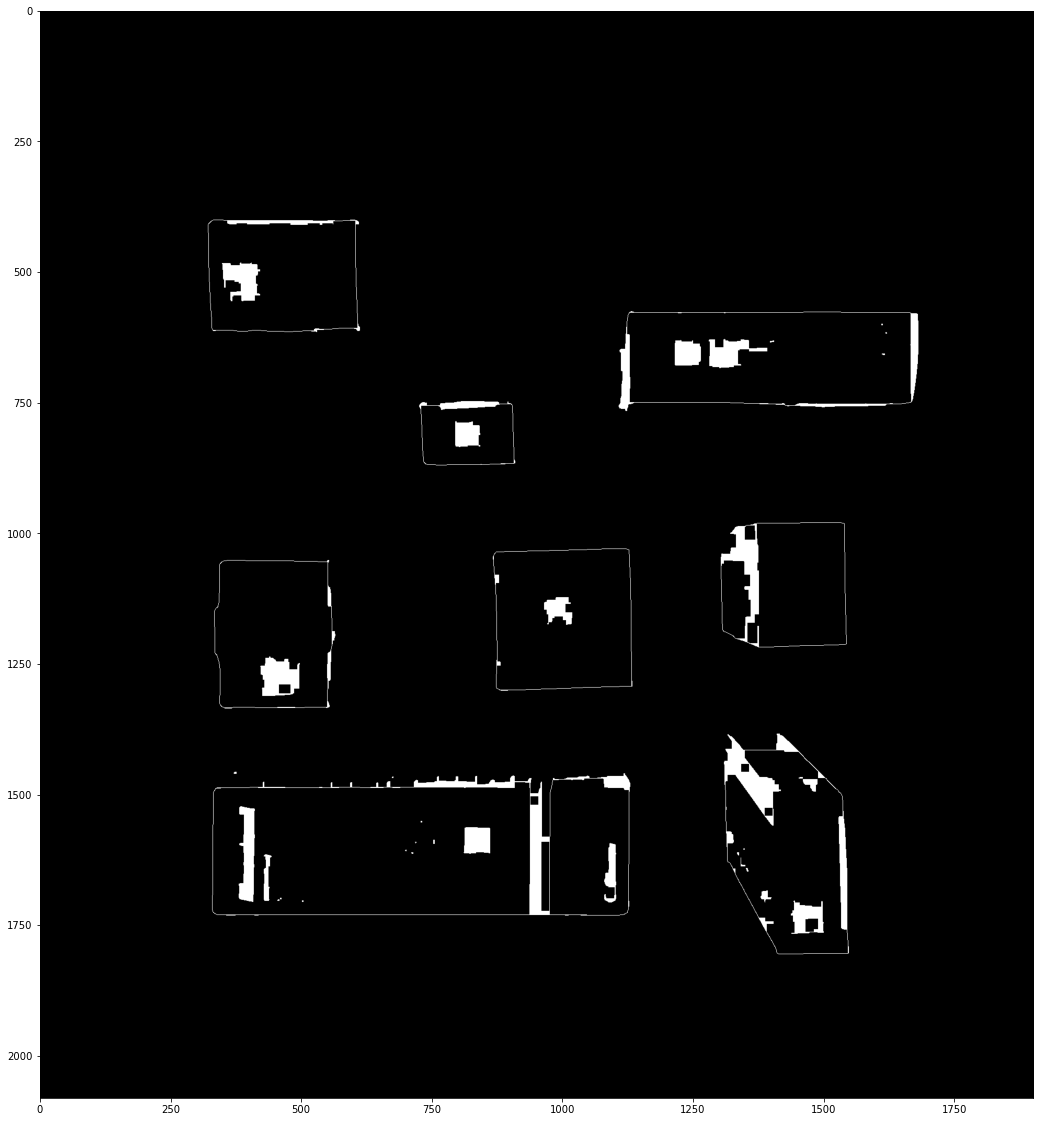

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(closed,cmap ='gray')

In [24]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

area_threshold = 50*50
aspect_ratio_threshold = 7
adjacency_threshold = 0.5

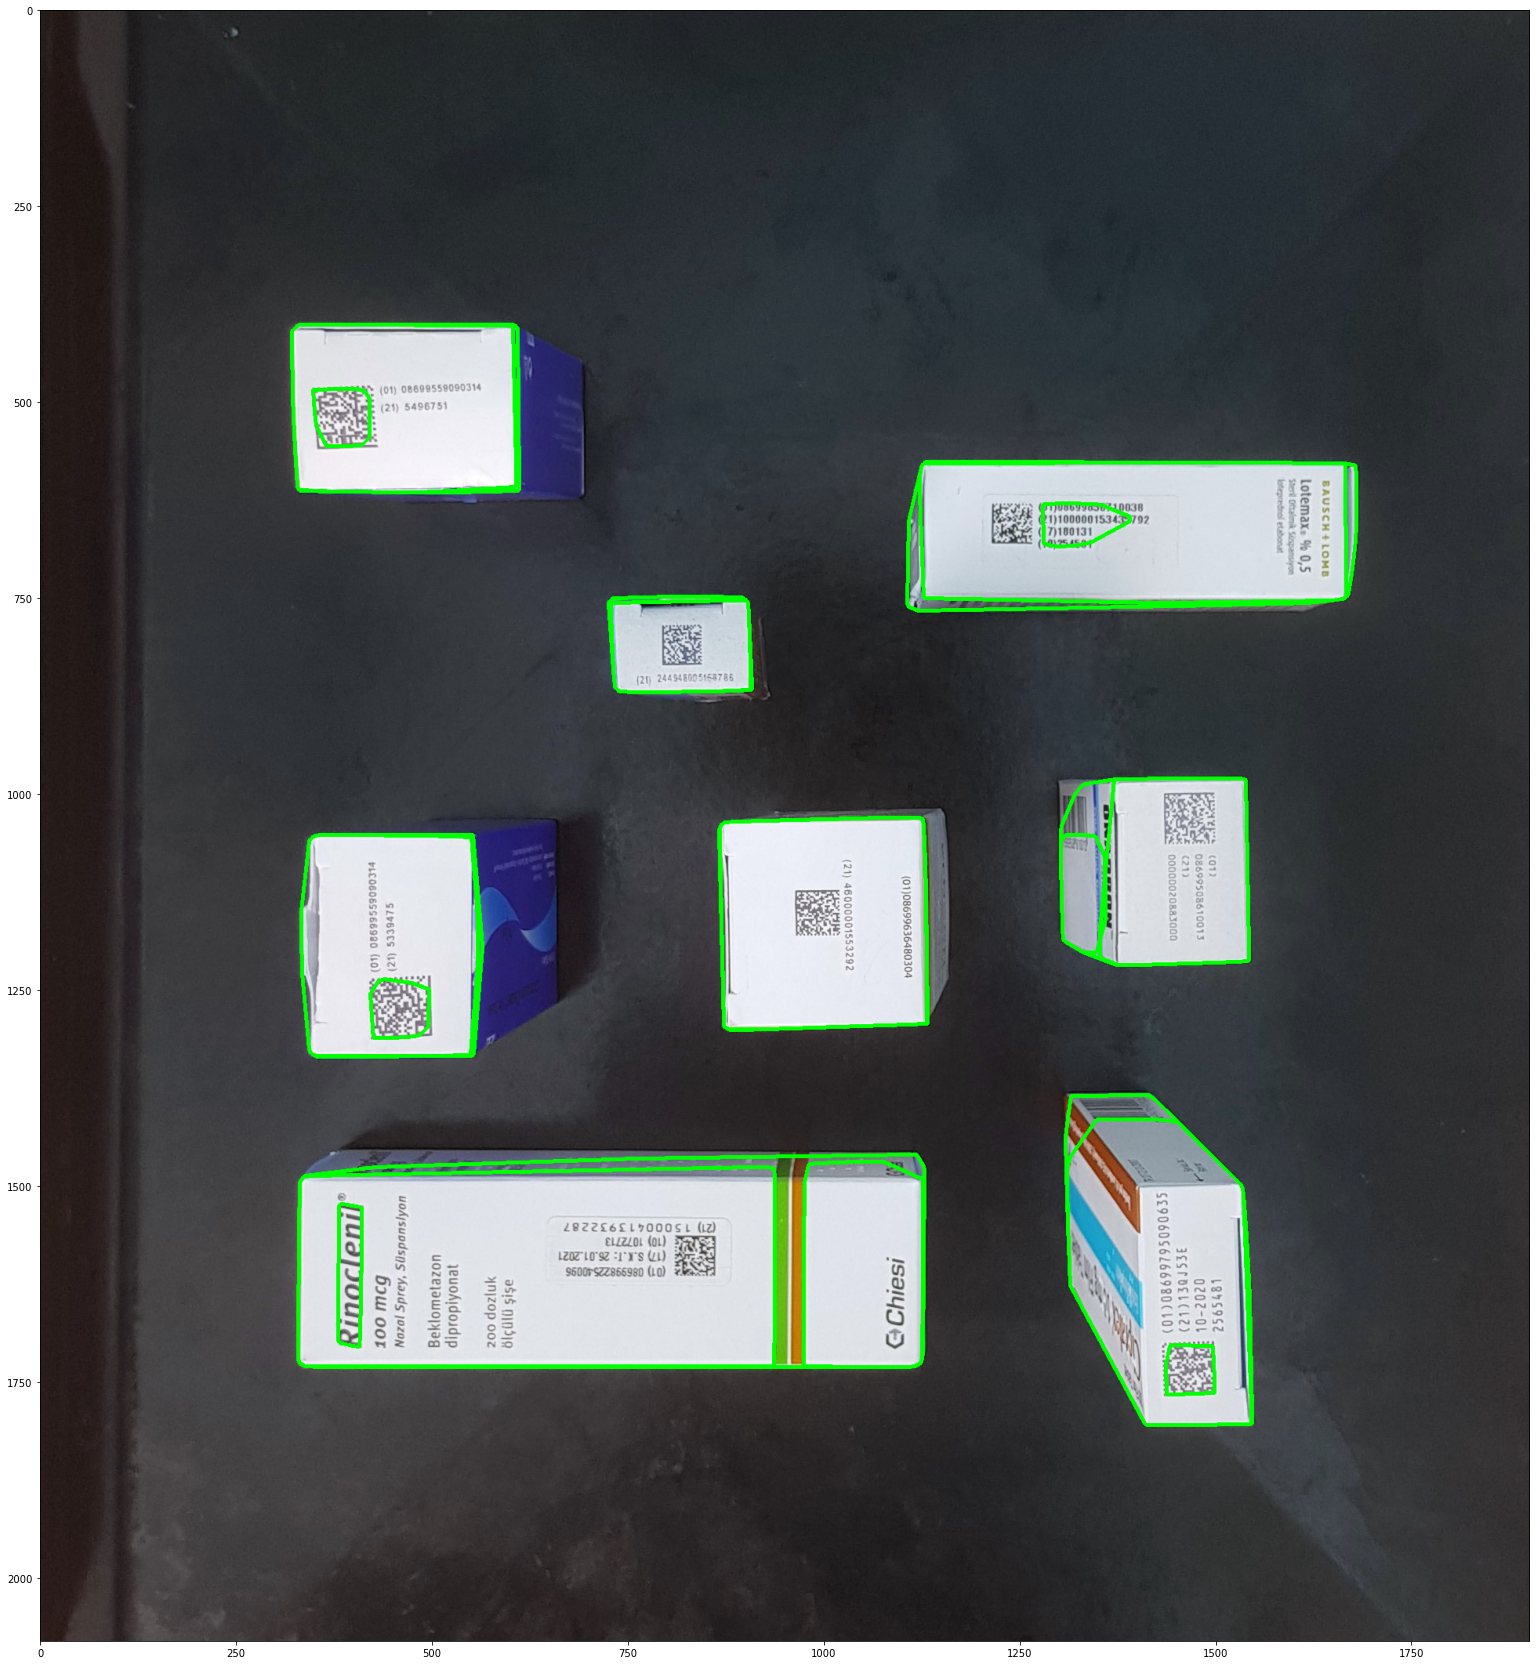

In [25]:
cs = []
for i in range(len(contours)):
    approx = cv2.convexHull(contours[i])

    if cv2.contourArea(approx)>area_threshold :
            cs.append(approx) 


cntim = image_coloured.copy()
cntim = cv2.drawContours(cntim, cs, -1, (0,255,0), 3)

plt.figure(figsize=(30,30))

plt.imshow(cntim)

## Box Detection

In [26]:
from shapely.geometry import Polygon,box

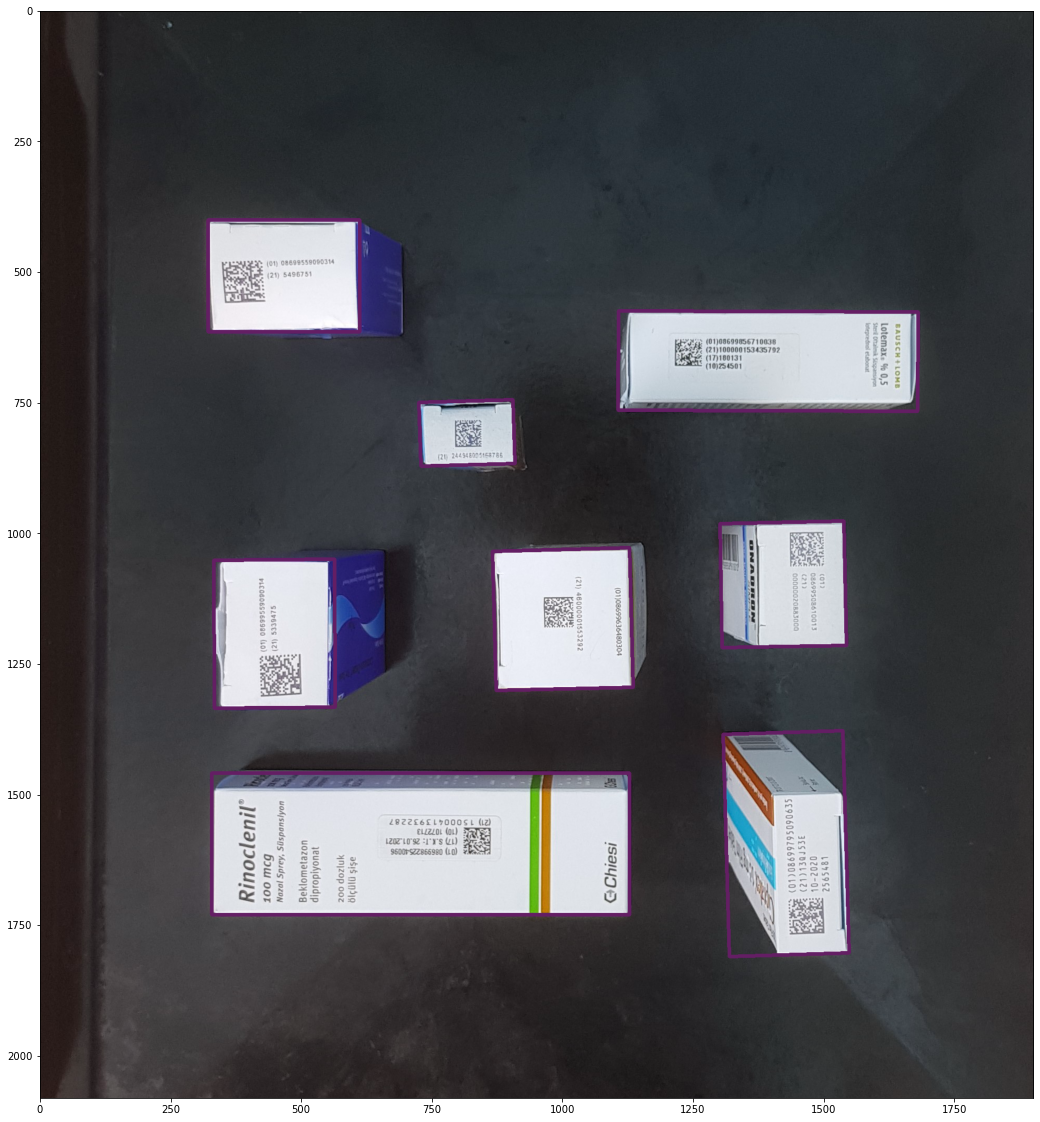

In [27]:
rects = []
boxes = []


for i in range(len(contours)):
    approx = cv2.convexHull(contours[i])
    
    contArea = cv2.contourArea(approx)
    
    #AREA THRESHOLD
    if contArea > area_threshold :
        
        rect = cv2.minAreaRect(approx)
        (x1,y1),(w1,h1),_ = rect
        
        rectArea = w1*h1
        
        #ASPECT RATIO MEASUREMENT
        aspect_ratio = w1/h1
        
        if 1/aspect_ratio_threshold < aspect_ratio < aspect_ratio_threshold :
            
            #SHAPE INTERACTIONS----------------------------------------------------------------------------------- 

            box = cv2.boxPoints(rect)
            box = np.int0(box) 
            boxPoly1 = Polygon(box)
            
            addRect = True
            
            j=0
            while j < len(rects):
                (x2,y2),(w2,h2),_ = rects[j]

                boxPoly2 = Polygon(boxes[j])
                
                #CHECK FOR DUPLICATES AND SHAPES AT EDGES OF FRAME
                if boxPoly1.almost_equals(boxPoly2, decimal=0) or boxPoly1.equals(boxPoly2) \
                or not boxPoly1.within(Polygon([(1,1),(1,image_h-2),(image_w-2,image_h-2),(image_w-2,1)])):
                    addRect = False
                    break     
                
                #FIND SHAPES CONTAINED IN SHAPES
                elif boxPoly1.contains(boxPoly2):
                    del rects[j]
                    del boxes[j]                        
                elif boxPoly1.within(boxPoly2):
                    addRect = False
                    break
                
                #FIND SHAPES CROSSING, TOUCHING OR IN CLOSE PROXIMITY (DETERMINED BY THRESHOLD)
                elif boxPoly1.crosses(boxPoly2) \
                or boxPoly1.touches(boxPoly2) \
                or boxPoly1.distance(boxPoly2) < min(w1,h1,w2,h2)*adjacency_threshold :

                    rectArea2 = w2*h2
                   
                    if rectArea <= rectArea2:       
                        addRect = False
                        break 
                    else:    
                        del rects[j]
                        del boxes[j]
                else: 
                    #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                    j+=1
                                          
            if addRect:
                rects.append(rect)
                boxes.append(box)
                #print("RECT: ",rect)

rect_img = image_coloured.copy()


cv2.drawContours(rect_img, boxes, -1, (100,30,100), 5) 
    

plt.figure(figsize=(20,20))

plt.imshow(rect_img)



#cv2.imwrite('C:/Users/User/Desktop/barcode_proj/images/results/white_background3.jpg',contoured)




## To Remove Duplicated DataMatrices

In [37]:
def removeDuplicates(boxes):
    i=0
    while i < len(boxes):
        poly1 = Polygon(boxes[i])
        j = i+1
        while j < len(boxes):
            poly2 = Polygon(boxes[j])
            if poly1.equals(poly2) or poly1.almost_equals(poly2, decimal=-1): del boxes[j]
                
            else: j += 1
        i +=1
    return boxes

## DataMatrix Detection Method - 1